# Cancer Outcomes & Cost Drivers — Patient-Level Analysis



**Objective.** Identify the top factors associated with **shorter survival** and **higher treatment cost** in cancer patients, and quantify their impact.

**Primary question (analytics problem):**  
> Which patient and clinical features most strongly explain **Survival_Years**?  

**Secondary question (cost lens):**  
> Which features drive **Treatment_Cost_USD**, and how does cost relate to disease severity?

**Business value / stakeholder view:**  
- Clinicians: early risk flags for patients likely to have shorter survival.  
- Hospital admin / payers: cost drivers that inform budgeting and care pathways.  
- Policy: country/region patterns that correlate with risk and cost.

**Success criteria (measurable):**  
- A ranked list of key drivers (effect sizes / feature importances).  
- Predictive baseline with clear, honest performance (e.g., RMSE/MAE for Survival_Years).  
- At least 3 actionable insights + 2 limitations.
  

## Data Card

- **Source:** [Kaggle — Cancer Patient Data](https://www.kaggle.com/) (public dataset, anonymized and non-identifiable).  
  
- **Unit of analysis:** Patient record (one row = one patient).  
- **Target(s):** `Survival_Years` (continuous), `Treatment_Cost_USD` (continuous).  
- **Key features (examples):** `Age`, `Gender`, `Country_Region`, `Year`, `Genetic_Risk`, `Air_Pollution`, `Alcohol_Use`, `Smoking`, `Obesity_Level`, `Cancer_Type`, `Cancer_Stage`, `Target_Severity_Score`.  
- **Assumptions:** Missing values are not systematic; zeros may be placeholders in certain numeric fields.  
- **Ethics:** This is a de-identified educational dataset; insights are illustrative and **not** clinical advice.


## Project Roadmap

1) **Data Understanding & Set-up** — quick audit of schema, missingness, and data quality.  
2) **Cleaning & Feature Prep** — type fixes, outlier/zero handling, categorical standardization, derived features.  
3) **EDA (Guided by the Problem)** — distributions and relationships, always tied back to survival and cost.  
4) **Modeling Baseline** — simple, transparent baseline (e.g., linear/logistic) with honest metrics.  
5) **Insights & Recommendations** — ranked drivers, cost levers, edge cases.  
6) **Limitations & Next Steps** — where the analysis may mislead, and how to improve.  
7) **Reproducibility** — environment, seeds, and a single `df` pipeline.

## Author  
Filza Aqeel

In [6]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling (will use later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


### Loading Dataset with Custom NA Handling  

The dataset contains various placeholders for missing values (e.g., `Na`, `--`, `Unknown`).  
We standardize them as proper `NaN` entries during import to ensure consistent cleaning.

In [8]:
missing = ["unknown","Unknown","NAN","Na","N/A","NA","na","--","","Nan","none","nan"]

# Load dataset with custom NA values
data= pd.read_csv("global_cancer_patients_uncleaned.csv", na_values=missing)

# Quick preview
data.head()



,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,high,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.8,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,NaN,Leukemia,Stage 0,12573.41,7.8,4.65
2,PT0000002,80,Male,NaN,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,6,5.84
3,PT0000003,40,1,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,NaN,2,77977.12,9,3.62


### Dataset Overview  

We inspect the dataset’s schema and data types to understand its structure.  
This helps identify categorical vs numerical features, and any potential issues in formatting.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             49988 non-null  object 
 1   Age                    50000 non-null  object 
 2   Gender                 50000 non-null  object 
 3   Country_Region         49998 non-null  object 
 4   Year                   49997 non-null  object 
 5   Genetic_Risk           49986 non-null  object 
 6   Air_Pollution          49986 non-null  float64
 7   Alcohol_Use            49986 non-null  object 
 8   Smoking                49987 non-null  object 
 9   Obesity_Level          49998 non-null  float64
 10  Cancer_Type            49998 non-null  object 
 11  Cancer_Stage           49996 non-null  object 
 12  Treatment_Cost_USD     49999 non-null  object 
 13  Survival_Years         50001 non-null  object 
 14  Target_Severity_Score  49999 non-null  float64
dtypes:

### Descriptive Statistics  

Summary statistics for numerical features give a first look at central tendencies and spread.  
This helps spot unusual ranges, skewness, and possible data entry errors.

In [12]:
data.describe()


,Air_Pollution,Obesity_Level,Target_Severity_Score
count,49986.000000,49998.000000,49999.000000
mean,5.010013,4.991044,4.949270
std,2.888484,2.894541,1.203224
min,0.000000,0.000000,0.000000
25%,2.500000,2.500000,4.120000
50%,5.000000,5.000000,4.950000
75%,7.500000,7.500000,5.780000
max,10.000000,10.000000,9.160000


In [13]:
data.shape

(50001, 15)

### Missing Values Audit  

We check how many missing values exist in each column.  
This informs how we handle gaps (e.g., imputation or removal).

In [15]:
data.isnull().sum()

Patient_ID               13
Age                       1
Gender                    1
Country_Region            3
Year                      4
Genetic_Risk             15
Air_Pollution            15
Alcohol_Use              15
Smoking                  14
Obesity_Level             3
Cancer_Type               3
Cancer_Stage              5
Treatment_Cost_USD        2
Survival_Years            0
Target_Severity_Score     2
dtype: int64

Most missing values are found in [Genetic_Risk, Air_Pollution, Alcohol_Use, Smoking].  
We will handle these by [dropping rows / filling with median or mode].  

In [17]:
# Fill missing numerical values with median
data.fillna(data.median(numeric_only=True), inplace=True)

# Fill missing categorical values with mode
for col in data.select_dtypes(include=['object']).columns:
    
    data[col].fillna(data[col].mode()[0], inplace=True)


C:\Users\ukash\AppData\Local\Temp\ipykernel_22672\2032528803.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


### Data Validation — Spotting Corrupt Values  

After basic cleaning, we inspect the **unique values** in key columns  
to catch inconsistencies (e.g., `1` vs `I` for Cancer_Stage, typos in Gender, corrupted Patient_IDs).  
We use `.value_counts()` and `.describe()` to flag anomalies.

In [19]:
data["Country_Region"].value_counts()

Country_Region
Australia    5092
UK           5061
USA          5060
India        5039
Germany      5023
Russia       5017
Brazil       5004
Pakistan     4924
China        4913
Canada       4863
aussie          2
pk              1
Aus             1
ind             1
Name: count, dtype: int64

In [20]:
data["Cancer_Type"].value_counts()

Cancer_Type
Colon       6379
Prostate    6307
Leukemia    6266
Liver       6249
Skin        6230
Cervical    6222
Breast      6188
Lung        6159
1              1
Name: count, dtype: int64

In [21]:
data["Gender"].value_counts()	

Gender
Male      16794
Female    16705
Other     16495
1             3
F             1
2             1
M             1
f             1
Name: count, dtype: int64

In [22]:
data["Cancer_Stage"].value_counts()

Cancer_Stage
Stage II     10126
Stage I      10045
Stage III    10005
Stage IV      9932
Stage 0       9887
2                3
0                1
1                1
3                1
Name: count, dtype: int64

In [23]:
data['Patient_ID'].value_counts(dropna=False).head(10)

Patient_ID
PT0000003    15
PT0000000     1
PT0033341     1
PT0033331     1
PT0033332     1
PT0033333     1
PT0033334     1
PT0033335     1
PT0033336     1
PT0033337     1
Name: count, dtype: int64

In [24]:
data['Survival_Years'].describe()
data['Survival_Years'].value_counts().sort_index().head(20)

Survival_Years
0      249
0.1    479
0.2    511
0.3    503
0.4    468
0.5    514
0.6    504
0.7    474
0.8    466
0.9    522
1      494
1.1    496
1.2    482
1.3    481
1.4    515
1.5    519
1.6    501
1.7    496
1.8    480
1.9    502
Name: count, dtype: int64

# Handling Inconsistent or Corrupted Data Values 

In [26]:
data['Patient_ID'] = ["PT" + str(i+1).zfill(7) for i in range(len(data))]

In [47]:
print("Duplicates:", data['Patient_ID'].duplicated().sum())

Duplicates: 0


### Handling Column: Patient_ID

Issues observed:  
- 13 missing Patient_IDs  
- Several duplicates (e.g., `PT0000003` appeared 15 times)  
- Isolated corrupted entries (e.g., `PT0033341`)  

Fix applied:  
- Regenerated new sequential IDs (`PT0000001`, `PT0000002`, …) based on row order.  
- Ensured no missing or duplicate identifiers remained.  

In [50]:
# Fix typo first
data["Age"] = data["Age"].replace("fourty", 40)

# Convert to numeric
data["Age"] = pd.to_numeric(data["Age"], errors="coerce")

# Fill any remaining NaNs with median age
data["Age"] = data["Age"].fillna(data["Age"].median())

# Finally convert to integer
data["Age"] = data["Age"].astype(int)

In [52]:
print("Min age:", data["Age"].min())
print("Max age:", data["Age"].max())
print("Missing ages:", data["Age"].isna().sum())

Min age: 20
Max age: 89
Missing ages: 0


### Handling Column: Age

- Identified one corrupted entry: `"fourty"`.  
- Replaced it with the correct numeric value `40`.  
- Converted Age to integer type for consistency.  

In [55]:
data["Gender"] = data["Gender"].replace({
    "f": "Female", "F": "Female", "2": "Female",
    "M": "Male", "1": "Male"
})
# Keep only 'Male' and 'Female' values
data["Gender"] = data["Gender"].where(data["Gender"].isin(["Male", "Female"]))

In [57]:
#handling null values
data["Gender"] = data["Gender"].fillna("Unknown")
print(data["Gender"].value_counts(normalize=True))

Gender
Male       0.335953
Female     0.334153
Unknown    0.329893
Name: proportion, dtype: float64


In [59]:
# Convert to numeric safely
data["Genetic_Risk"]=pd.to_numeric(data["Genetic_Risk"],errors="coerce")
# Fill missing with median (likely 2 = Medium)
data["Genetic_Risk"]=data["Genetic_Risk"].fillna(data["Genetic_Risk"].median())

### Handling Column: Genetic_Risk  

- Converted to numeric and coerced invalid entries to NaN.  
- Imputed missing values using the median score.  

In [62]:
# Convert to numeric
data["Air_Pollution"] = pd.to_numeric(data["Air_Pollution"], errors="coerce")

# Treat invalid values
data.loc[data["Air_Pollution"] < 0, "Air_Pollution"] = np.nan

# Impute with median
data["Air_Pollution"] = data["Air_Pollution"].fillna(data["Air_Pollution"].median())

### Handling Column: Air_Pollution

- Converted column to numeric and coerced invalid text into NaN.  
- Treated negative values as invalid and set them to NaN.  
- Replaced missing/invalid values with the median exposure level.  
- This ensures the feature is consistent and usable as a predictor.  


In [65]:
# First replace "FALSE" with 0
data["Alcohol_Use"] = data["Alcohol_Use"].replace("FALSE", 0)

# Convert everything to numeric
data["Alcohol_Use"] = pd.to_numeric(data["Alcohol_Use"], errors="coerce")

# Remove impossible negatives
data.loc[data["Alcohol_Use"] < 0, "Alcohol_Use"] = np.nan

# Impute missing/invalid with median
data["Alcohol_Use"] = data["Alcohol_Use"].fillna(data["Alcohol_Use"].median())

### Handling Column: Alcohol_Use

- Column represents alcohol use scores (0–10).  
- Found a stray `"FALSE"` entry → replaced with `0`.  
- Converted all values to numeric and coerced invalid text into NaN.  
- Negative values treated as invalid.  
- Missing/invalid values imputed with the **median alcohol use score**

In [68]:
# Standardize case + strip spaces
data["Country_Region"] = data["Country_Region"].str.strip().str.title()

# Fix common variations
country_fixes = {
    "Uk": "United Kingdom",
    "Usa": "United States",
    "Pk": "Pakistan",
    "Ind": "India",
    "Aussie": "Australia",
    "Aus": "Australia"
}
data["Country_Region"] = data["Country_Region"].replace(country_fixes)


### Handling Column: Country_Region 
- Found inconsistent entries such as `aussie`, `pk`, `ind`, `Aus`, `UK`, `USA`.  
- Standardized formatting to title case.  
- Replaced these variations with the correct country names.  
- Ensured all countries are consistently labeled for analysis.  


In [71]:
# Convert to numeric
data["Smoking"] = pd.to_numeric(data["Smoking"], errors="coerce")

# Treat invalid negatives
data.loc[data["Smoking"] < 0, "Smoking"] = np.nan

# Fill missing/invalid with median
data["Smoking"] = data["Smoking"].fillna(data["Smoking"].median())

### Handling Column: Smoking

- Column represents smoking exposure scores (numeric).  
- Found a few corrupted text entries (`"False"`, `"Na"`).  
- Converted all values to numeric, coercing invalid entries into NaN.  
- Negative values treated as invalid.  
- Missing/invalid values imputed with the **median smoking score**.  

In [74]:
data["Obesity_Level"].value_counts()

Obesity_Level
8.3     566
8.2     563
6.8     560
1.4     554
2.7     548
       ... 
1.1     450
8.1     447
6.5     445
10.0    247
0.0     242
Name: count, Length: 101, dtype: int64

In [76]:
data["Obesity_Level"].isnull().sum()

0

In [78]:
# Convert to numeric (safeguard)
data["Obesity_Level"] = pd.to_numeric(data["Obesity_Level"], errors="coerce")

# Remove impossible negatives
data.loc[data["Obesity_Level"] < 0, "Obesity_Level"] = np.nan

# Fill missing/invalid with median
data["Obesity_Level"] = data["Obesity_Level"].fillna(data["Obesity_Level"].median())

### Handling Column: Obesity_Level

- Converted all entries to numeric, coercing invalid text into NaN.  
- Negative values treated as invalid.  
- Missing/invalid values imputed with the **median obesity level score**.  
- This ensures the feature is consistent with other lifestyle risk factors.  


In [81]:
def check_cancer_type(x):
    cancers = ["Colon", "Prostate", "Leukemia", "Liver", "Skin", "Cervical", "Breast", "Lung"]
    if x in cancers:
        return x
    else:
        return "Other"

data["Cancer_Type"] = data["Cancer_Type"].apply(check_cancer_type)

### Handling Column: Cancer_Type
- Restricted cancer types to a curated list of 8 most frequent categories.  
- Any entry outside this list was grouped into `"Other"` instead of mode imputation (avoids bias).  
- This preserves signal while reducing noise from rare/unexpected entries.  


In [84]:
def check_Cancer_Stage(x):
    stages=["Stage I","Stage II","Stage III","Stage IV","Stage 0"]
    wrong_stages={"2":"Stage II","0":"Stage 0","1":"Stage I","3":"Stage III","4":"Stage IV"}
    if x in stages:
        return x
    elif x in wrong_stages:
        return wrong_stages[x]
    else:
        return data["Cancer_Stage"].mode()[0]

data["Cancer_Stage"]=data["Cancer_Stage"].apply(check_Cancer_Stage)

### Handling Column: Cancer_stage
- Found inconsistent labels: `"1"`, `"2"`, `"3"`, `"4"` instead of Roman numerals.  
- Replaced them with correct values: `"Stage I"`, `"Stage II"`, `"Stage III"`, `"Stage IV"`.  
- For corrupted or missing entries, used the mode (most frequent stage) as imputation.  

In [87]:
def currency_converter(x):
    if pd.isna(x):
        return np.nan
    new_value = str(x).replace("$", "").replace("Rs.", "").replace("Rs", "").replace(",", "").strip()
    try:
        return float(new_value)
    except ValueError:
        return np.nan

data["Treatment_Cost_USD"] = data["Treatment_Cost_USD"].apply(currency_converter)




### Cleaning currency formats in Treatment_Cost_USD

- Found inconsistent formats: `$5000`, `Rs. 300,000`, `12,000`.  
- Wrote a custom function to strip currency symbols & commas, then convert to float.  
- Invalid entries converted to NaN.  


In [90]:
index = 0
for rows in data["Treatment_Cost_USD"]:
    if rows < 0:  # invalid cost
        data.loc[index, "Treatment_Cost_USD"] = np.nan
    index += 1

# Fill missing/invalid with median
data["Treatment_Cost_USD"] = data["Treatment_Cost_USD"].fillna(data["Treatment_Cost_USD"].median())

### Handling invalid and missing values in Treatment_Cost_USD

- Identified negative costs → treated as invalid, set to NaN.  
- Replaced missing/invalid values with the **median treatment cost**.  
- This ensures cost data is realistic and ready for analysis.  



In [93]:
# Convert to numeric, coerce errors
data["Survival_Years"] = pd.to_numeric(data["Survival_Years"], errors="coerce")

# Handle negatives (impossible)
data.loc[data["Survival_Years"] < 0, "Survival_Years"] = np.nan

# Handle extreme unrealistic values (say > 120 years)
data.loc[data["Survival_Years"] > 120, "Survival_Years"] = np.nan

# Impute missing with median survival
data["Survival_Years"] = data["Survival_Years"].fillna(data["Survival_Years"].median())

### Handling Column: Survival_Years  

- Converted column to numeric and coerced invalid entries to NaN.  
- Removed biologically implausible values (negative survival years or values >120).  
- Imputed missing values with the median survival years.  
- This ensured the variable reflects realistic patient outcomes for further analysis.  


In [96]:
# Drop unnecessary columns
data = data.drop(columns=["Patient_ID", "Year", "Target_Severity_Score"], errors="ignore")

# Check remaining columns
print("Remaining columns:", data.columns.tolist())

Remaining columns: ['Age', 'Gender', 'Country_Region', 'Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level', 'Cancer_Type', 'Cancer_Stage', 'Treatment_Cost_USD', 'Survival_Years']


### Dropping Non-Essential Columns

- Dropped columns not relevant to our objectives:  
  - `Patient_ID` (identifier, no predictive value)  
  - `Year` (time reference, not needed for driver analysis)  
  - `Target_Severity_Score` (synthetic column, redundant with stage/risk)  
- This leaves only patient, clinical, lifestyle, and cost/survival variables for analysis.  


## Exploratory Data Analysis Plan

- **Survival_Years**
  - Distribution (histogram, summary stats).  
  - Compare across Cancer_Stage, Cancer_Type, Gender, Age groups.  
- **Treatment_Cost_USD**
  - Distribution (histogram).  
  - Compare across Cancer_Stage, Cancer_Type, Survival_Years.  
- **Correlation Analysis**
  - Heatmap of numeric features (Age, Genetic_Risk, Smoking, Alcohol_Use, Obesity_Level, Air_Pollution) with Survival_Years and Treatment_Cost_USD.  



### Distribution of Survival_Years

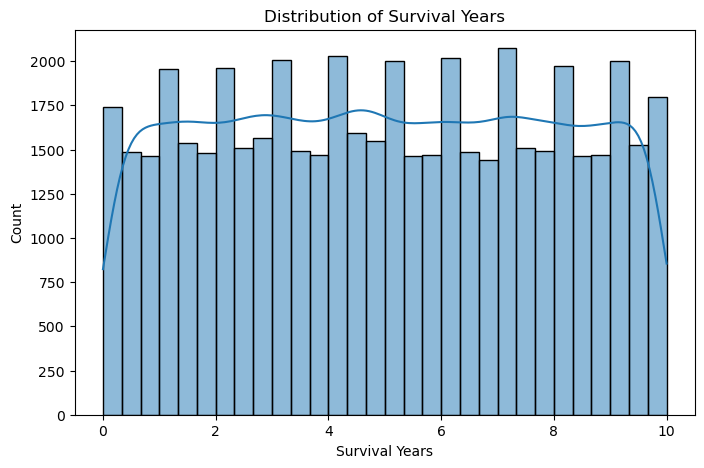

In [147]:
# histogram
plt.figure(figsize=(8,5))
sns.histplot(data["Survival_Years"], bins=30, kde=True)
plt.title("Distribution of Survival Years")
plt.xlabel("Survival Years")
plt.ylabel("Count")
plt.show()

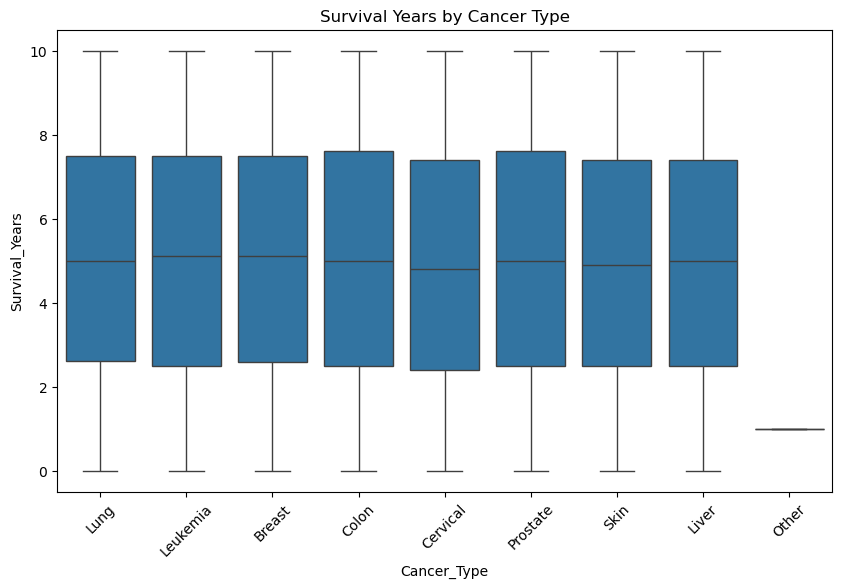

In [161]:
# Survival_Years vs Cancer Type
plt.figure(figsize=(10,6))
sns.boxplot(x="Cancer_Type", y="Survival_Years", data=data)
plt.title("Survival Years by Cancer Type")
plt.xticks(rotation=45)
plt.show()

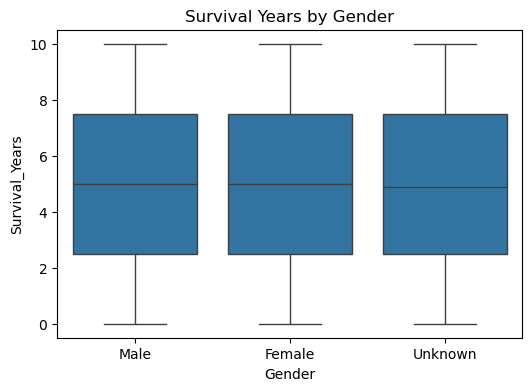

In [153]:
# Survival_Years vs Gender
plt.figure(figsize=(6,4))
sns.boxplot(x="Gender", y="Survival_Years", data=data)
plt.title("Survival Years by Gender")
plt.show()


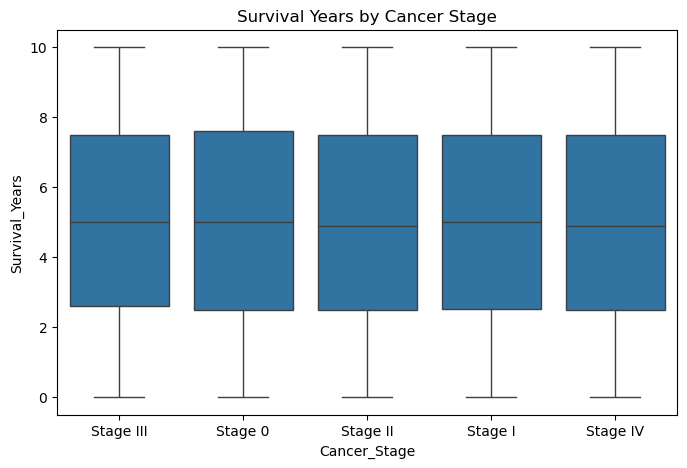

In [151]:
#Survival_Years vs Cancer Stage
plt.figure(figsize=(8,5))
sns.boxplot(x="Cancer_Stage", y="Survival_Years", data=data)
plt.title("Survival Years by Cancer Stage")
plt.show()


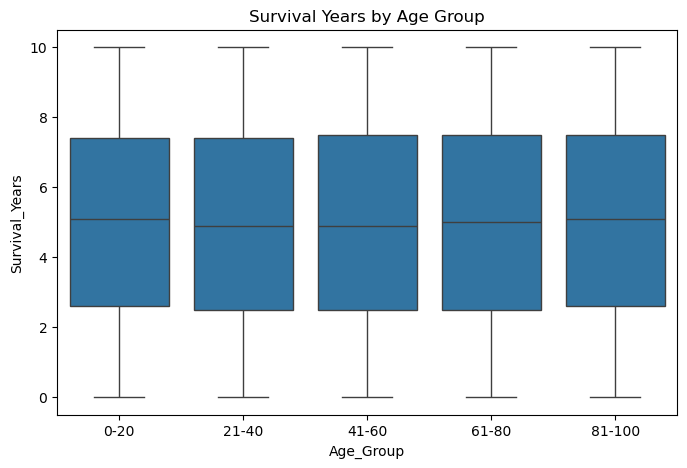

In [149]:
# Survival_Years vs Age Groups
# create age groups
bins = [0,20,40,60,80,100]
labels = ["0-20","21-40","41-60","61-80","81-100"]
data["Age_Group"] = pd.cut(data["Age"], bins=bins, labels=labels, right=True)

plt.figure(figsize=(8,5))
sns.boxplot(x="Age_Group", y="Survival_Years", data=data)
plt.title("Survival Years by Age Group")
plt.show()

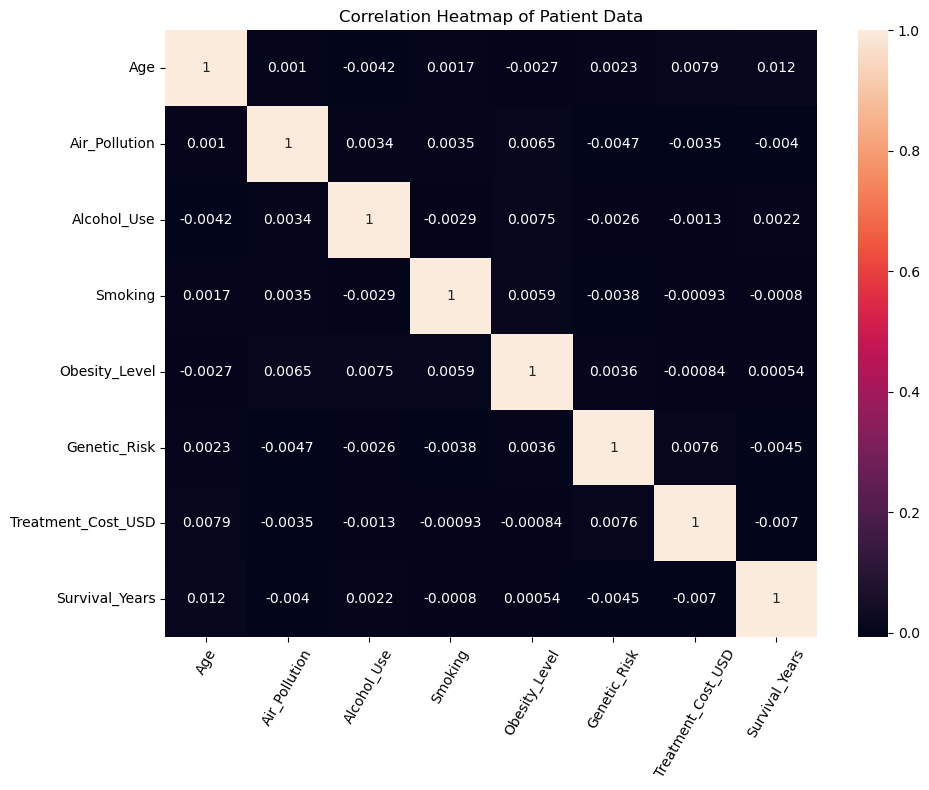

In [113]:
#make heatmap 

# Convert relevant columns to numeric, coercing errors
numerical_cols = [
    'Age', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 
    'Obesity_Level', 'Genetic_Risk', 'Treatment_Cost_USD', 
    'Survival_Years']
data[numerical_cols] = data[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Compute correlation matrix
correlation_matrix = data[numerical_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap of Patient Data')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()